In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas_profiling as pp

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
pd.set_option('display.max_columns',50)

In [16]:
from sklearn.manifold import Isomap, TSNE, t_sne
from sklearn.decomposition import PCA

In [7]:
from sklearn.linear_model import ARDRegression

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score,RandomizedSearchCV, GridSearchCV, StratifiedKFold, KFold, cross_val_predict, cross_validate, LeaveOneOut
from sklearn.linear_model import ARDRegression, Lasso, LassoCV, LogisticRegression, Ridge, RidgeCV, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [5]:
data=pd.read_csv('Syntetic_IT_project.csv')

In [6]:
data

,Project ID,Project goals,Top management support,Project schedule/ plan,Client consultation,Team,Technical tasks,Client acceptance,Monitoring and feedback,Communication,TARGET Success
0,MyELIT_iOS,8,5,4,7,8,9,7,8,8,8
1,MyELIT_Android,8,4,4,5,7,7,5,5,8,7
2,MyELIT_WP,6,7,6,6,5,5,4,2,3,4
3,ELIT_web,9,9,8,8,9,8,5,5,7,6
4,IT People Sumy,10,8,7,10,6,6,6,7,6,6
5,Phsyhology,10,8,9,9,7,5,8,4,5,5
6,Budnyk,10,9,8,7,7,8,7,5,6,7
7,Nesterov,7,6,5,5,5,4,3,3,4,5
8,Doroshkova,9,10,8,9,6,5,8,7,9,9
9,Marchenko,5,6,8,8,4,3,5,4,8,4


# Тут починається частина коду в статтю

In [276]:
# Подивимося на перші пять строк нашого датасету, щоб ми мали уявлення, що саме за данні ми маємо
data.head()

,Project ID,Project goals,Top management support,Project schedule/ plan,Client consultation,Team,Technical tasks,Client acceptance,Monitoring and feedback,Communication,TARGET Success
0,MyELIT_iOS,8,5,4,7,8,9,7,8,8,8
1,MyELIT_Android,8,4,4,5,7,7,5,5,8,7
2,MyELIT_WP,6,7,6,6,5,5,4,2,3,4
3,ELIT_web,9,9,8,8,9,8,5,5,7,6
4,IT People Sumy,10,8,7,10,6,6,6,7,6,6


In [278]:
# Підготуємо данні, відокремо таргет та сформуємо Xtrain та ytrain
Xtrain=data.iloc[:,1:-1]
ytrain=data.iloc[:,-1]
#Перевіримо розмір отриманих масивів
Xtrain.shape, ytrain.shape

((20, 9), (20,))

### Спершу спробуємо ARDRegression() і побачимо, які саме фітчі важливі і впливають на таргет

In [280]:
ard = ARDRegression()
ard.fit(Xtrain, ytrain)
# Чим вище значення коефіцієнту тим він більше важливий для Таргету
print (ard.coef_)

[ 1.92557895e-03 -9.51988416e-04 -2.13868725e-04 -7.21210062e-04
  1.51514818e-02  4.13840050e-01  5.14818026e-01  8.82658008e-04
  9.09728493e-04]


### Відсортуємо значення коефіцієнтів за їх зменшенням, оскільки так простіше аналізувати фітче імпотанс

In [298]:
ard_df=pd.DataFrame(columns=['Features_name', 'best_ard.coef_' ])
ard_df['Features_name']=Xtrain.columns
ard_df['best_ard.coef_']=ard.coef_
ard_df=ard_df.sort_values(by='best_ard.coef_', ascending=False)
ard_df

ard_df.to_csv('features importance_ard.csv')
ard_df

,Features_name,best_ard.coef_
6,Client acceptance,0.514818
5,Technical tasks,0.413840
4,Team,0.015151
0,Project goals,0.001926
8,Communication,0.000910
7,Monitoring and\nfeedback,0.000883
2,Project schedule/\nplan,-0.000214
3,Client consultation,-0.000721
1,Top management\nsupport,-0.000952


### Як ми бачимо важливими є фітчі (в порядку зменшення важливості):
#### Client acceptance, Technical tasks, Team, Project goals .....

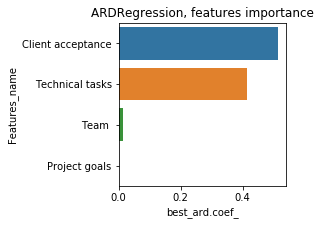

In [285]:
# Теж саме, що вище побудуємо у вигляді стовпчиків
# Якщо, потрібний буде цей графік, можу прислати
plt.figure(figsize=(3,3))
plt.title('ARDRegression, features importance')
sns.barplot( y ='Features_name', x='best_ard.coef_', data=ard_df.iloc[:4], orient='h')
plt.savefig('ARD_features importance', dpi=300, bbox_inches = "tight")

In [306]:
# Також порахуємо коефіцієнт детермінації, для того щоб розуміти наскільки гарно ми описуємо данні
r2_score(ytrain.values, ard.predict(Xtrain))

0.72487110422389

## Тепер проаналізуємо, наскільки наша модель чуттєва до шуму 
### Згенеруємо декілько шумових фітч і подивимося, чи зможе їх розпізнати модель
### Чи зміняться коефіцієнти та фітче імпотанс?
### Чи це якось завадить робити вірний предікт?

In [252]:
# Створимо масив (розміром 20Х2) із двох шумових фітч з нормального розподілу
X=pd.DataFrame(np.round((2*np.random.randn(20, 2) + 5)))

In [307]:
# Подивимося на перші 5 строчек, що за шум ми згенерували
X.head()

,0,1
0,5.0,8.0
1,7.0,5.0
2,7.0,3.0
3,3.0,5.0
4,6.0,6.0


In [269]:
# Підєднаємо шумові фітчі до нашого датафрейму (з права), новий датафрейм назвимо X_noise
X_noise=pd.concat([Xtrain, X.astype('int')], axis=1)
# Подивимося на перші 5 строчек нового датафрейму, як ми бачимо шумові фітчі зявилися праворуч
X_noise.head()

,Project goals,Top management support,Project schedule/ plan,Client consultation,Team,Technical tasks,Client acceptance,Monitoring and feedback,Communication,0,1
0,8,5,4,7,8,9,7,8,8,5,8
1,8,4,4,5,7,7,5,5,8,7,5
2,6,7,6,6,5,5,4,2,3,7,3
3,9,9,8,8,9,8,5,5,7,3,5
4,10,8,7,10,6,6,6,7,6,6,6


### Створимо ще один обєкт ARDRegression() і побачимо, які саме фітчі важливі і впливають на таргет
### Подивимося що змінилося і порівняємо два результати

In [291]:
ard_noise = ARDRegression()
ard_noise.fit(X_noise, ytrain)

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, threshold_lambda=10000.0, tol=0.001, verbose=False)

In [293]:
# Подивимося на нові коефіцієнти (шумові фітчі це два останніх значення,
# як ми бачимо вони отримали коеф.: нуль, та 1-03)
ard_noise.coef_

array([ 1.92393898e-03, -9.52608951e-04, -2.52979285e-04, -7.15347665e-04,
        1.49473139e-02,  4.13445502e-01,  5.15326878e-01,  8.88297199e-04,
        9.18053980e-04,  0.00000000e+00, -1.42899530e-03])

In [296]:
# Виведемо тут попередні коефіцієнти моделі (без шумових фітч)
# Якщо їх порівняти, то видно, що вони практично однакові. Іншими словами модель розпізнала шум,
# та не надала йому ніякої ваги, недивлячись на те що датасет дуже маленький
ard.coef_

array([ 1.92557895e-03, -9.51988416e-04, -2.13868725e-04, -7.21210062e-04,
        1.51514818e-02,  4.13840050e-01,  5.14818026e-01,  8.82658008e-04,
        9.09728493e-04])

### Відсортуємо значення коефіцієнтів за їх зменшенням, оскільки так простіше аналізувати фітче імпотанс

In [297]:
ard_df=pd.DataFrame(columns=['Features_name', 'best_ard.coef_' ])
ard_df['Features_name']=X_noise.columns
ard_df['best_ard.coef_']=ard_noise.coef_
ard_df=ard_df.sort_values(by='best_ard.coef_', ascending=False)
ard_df


ard_df

,Features_name,best_ard.coef_
6,Client acceptance,0.515327
5,Technical tasks,0.413446
4,Team,0.014947
0,Project goals,0.001924
8,Communication,0.000918
7,Monitoring and\nfeedback,0.000888
9,0,0.000000
2,Project schedule/\nplan,-0.000253
3,Client consultation,-0.000715
1,Top management\nsupport,-0.000953


### Як видно вище, шумові фітчі "0" та "1" моделлю вважаються за непотрібні

### Як ми бачимо важливими є фітчі (в порядку зменшення важливості):
### Client acceptance, Technical tasks, Team, Project goals ..... Повністтю аналогічні тому, коли в нас немає шуму

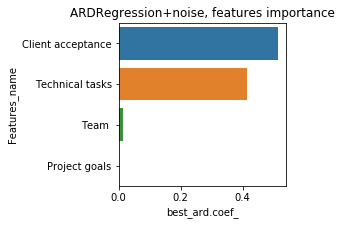

In [302]:
# Теж саме, що вище побудуємо у вигляді стовпчиків
# Якщо, потрібний буде цей графік, можу прислати
plt.figure(figsize=(3,3))
plt.title('ARDRegression+noise, features importance')
sns.barplot( y ='Features_name', x='best_ard.coef_', data=ard_df.iloc[:4], orient='h')
plt.savefig('ARD_features_noise importance', dpi=300, bbox_inches = "tight")

In [305]:
# Також порахуємо коефіцієнт детермінації, для того щоб розуміти наскільки гарно ми описуємо данні
# Як ми бачимо він практично не змінився
r2_score(ytrain.values, ard_noise.predict(X_noise))

0.7250373433088957

## Висновок, незважаючи на невеличкий датасет та зашумлені данні, модель змогла розпізнати додаткові шумові фічті і це не вплинуло на фіче імотанс та значення коефіцієнту детермінації